# CAR ACCIDENTS IN SWITZERLAND

## The Pizzafels

### Notebook for milestone 3

## Introduction

This notebook presents our analysis of the car accidents in Switzerland over the past years. From the different datasets that could be correlated to the accidents that we found online on the Swiss OpenData platform, we wanted to identify the ones with the highest impact, so as to be able to make predictions for the future and advise the government/the cantons on the matter.

### Important prior note

We tried to keep a clean tracking of the data in English, but it would have been a pain to manually rewrite every French - German - Italian - Romansh (yes, it exists) information in Shakespeare's language. This is why you can see some of the Swiss languages sometimes in our data, for example in the names of the dataframes, or their columns. We are sorry for the inconvenient and we commented it in a way that is hopefully sufficiently clear to understand what is going on even if you solely understand English!

### .Imports

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


### .Constants

In [2]:
DATA_FOLDER = 'data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$") #will be useful to detect values that correspond to dates

### .Useful functions

#### Function to quickly describe a dataframe

In [3]:
def describeDf(df,name="DESCRIPTION",level=2):
    """
    Describe the data. Different levels are possible.
    Level 0: Print the title of the dataset
    Level 1: Name the different columns
    Level 2: Explore the values of each column
    """
    date=[]
    
    # Explore each column of the dataset
    if(level==2):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        print("\n")
        for col in df.columns:
            # Print the attributes of each column
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        # Print the years we have information on
        print("         VALUES: "+str(date))
        print("\n\n\n")
        return
    
    # Recover and print the columns of the datasets
    elif(level==1):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        val = []
        # Print the different columns
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                val.append(col)
        print(val)
        print("\n\n\n")
        return
    
    # Simply print the name of the dataset
    elif(level==0):
        print("   >  " + name+"\n")
    
    # Sanity check: the given level does exist
    else:
        raise NotImplementedError

#### Function to restrict the dataframe to a fix period in term of years

We need this function as our different datasets are often based on different yearly periods.

In [4]:
def get_period(df, start=None,end=None):
    """
    Function to keep the columns of interest of a dataset, between a starting and an ending date.
    """
    columns_to_keep = []
    dates = []
    
    # Go through the columns
    for elem in df.columns:
        # If it is not a date we keep it
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        # Else we store it to see later if we keep it
        else:
            dates.append(int(elem))
    
    # Define the starting and ending dates in the case they are not
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    # Only keep the columns of interest
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervals as input

Using this functions will allow us to treat people between 40 and 50 years old as one group for example. Again, this is needed because of the disparity among the datasets, with some of them considering each age category differently, while others  groupped the people in different intervals. This functions allow us to compare and work with those different datasets.

In [5]:
def map_int_to_age(k,age_max):
    """
    Transform an integer to what is define as an age, i.e. 20 to '20 ans' ('20 years old')
    """
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

In [6]:
def build_age(intervals,age_max):
    """
    INPUT:  intervals: Array corresponding to the delimitation of the wanted intervals.
            age_max: The maximal age to consider.
    """
    ages_total = []
    
    # Build the intervals
    for i in range(len(intervals)-1):
        ages = []
        
        # We keep the first limit of the interval as its first element: this will
        # allow us to identify the different intervals later
        ages.append(intervals[i])
        
        # Put the corresponding ages in the interval
        for k in range(int(intervals[i]),int(intervals[i+1])):
            # Use our function
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
                
        # Store the interval we just created
        ages_total.append(ages)
    
    return ages_total

#### Mapping for the cantons

One recurrent problem we encountered, as presented in introduction, is the fact that different datasets have information in different languages. In general, we can treat them case by case, but it becomes a major issue when it comes to the Swiss cantons. As we wanted to do an in depth analysis and comparison of them, we needed to be able to refer them in different datasets.

We thus decided to build a dictionnary of every different mentioning of the cantons we found, with a little function to get the corresponding key, allowing us to compare cantons in different datasets.

In [7]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt']
dict_cantons['FR'] = ['Fribourg', 'Freiburg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen', 'Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']


def getKeysByValue(dictOfElements, valueToFind):
    '''
    Find the key of a canton.
    '''
    for item  in dictOfElements.items():
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

#### Function to plot a set of data

In [8]:
def plot_dataframe(x, y, title, xlabel, ylabel, labels, rotation=0, number_to_plot=None):  
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=23)
    if number_to_plot == None:
        number_to_plot = y.shape[0]
    for j in range(number_to_plot):
        plt.plot(x, y.iloc[j], label = labels[j])
    plt.legend(fontsize=15, loc="upper left", bbox_to_anchor=(1,1))
    plt.xticks(rotation=rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.show()

### .Datasets Loading

As mentioned, to perform our analysis, we took many datasets from the Swiss OpenData website. All these datasets are excels spreedsheet in differents forms, we hence needed to do a pre-treatment to transform them into clear `csv`
 files. They are stored in the folder `data_clean`.

The pre-treatment was huge since the datasets were sometimes split into multiple spreedsheets (on for each year) for example. Moreover, the excel files were organized to be visually good looking, with many merged cells and various hierachical levels in the data, thus requiring more work to clean and ready it for the future processings with pandas. 

#### Snapshot of our different datasets

In [9]:
dataframes = {}
print("  DATAFRAMES AVAILABLES:\n")

for file in os.listdir(DATA_FOLDER):
    # Load the filename
    filename = os.fsdecode(file)
    # Name the corresponding DataFrame "df_....."
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    # Load the values in the DataFrame
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    # Print the title of the datasets
    describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename]
    
    

  DATAFRAMES AVAILABLES:

   >  df_Qualite_vie_agglo

   >  df_Depense_menages_canton

   >  df_hacked_accident

   >  df_Population_age_1992

   >  df_Accident_cantons

   >  df_Frais_routes_cantonales

   >  df_Frais_routes_nationales

   >  df_Population_canton_1992

   >  df_Longueur_routes

   >  df_Accident_type_route

   >  df_proportion_permis

   >  df_Population_2010

   >  df_Accident_circonstances

   >  df_Recettes_routes

   >  df_Besoin_sante

   >  df_Accident_objets

   >  df_Voitures

   >  df_Frais_routes_communales

   >  df_Accident_victimes



# ANALYSIS

## 1. Accidents in Switzerland: A description

### 1.1. Who?

#### 1.1.1 Sex and age 

In this part, we work with the dataset `df_Population_2010`, which records the population by canton, sex and age between 2010 \& 2017. We change the disposition of the dataframe and group it by age and sex for each year. We then consider `df_Population_Age_1992` to have access to the population by age and sex between 1992 \& 2010 and put it in the same form. 

This will allow us to perform a normalization of the number of accidents (by 10'000 people in that case) to have an insight on the more dangerous categories of people.

##### Sex and age of the population on a yearly basis

2010-2017

In [10]:
# Build the age intervals corresponding to the ones in 'df_Accident_objets' with our function
ages = build_age(df_Accident_objets.age_index.unique(),100)

# Group the population by the age intervals to be considered
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    # Sum the population of each age in the interval considered and indexing the column
    # by the index of each interval (the number stored at position 0)
    df_Population_2010_trancheAge[str(age[0])] =\
            df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

# Define the columns of the dataframe we want to keep, i.e. the population for each interval
# of ages, the corresponding year and the sex
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

# We are only interested in the total Swiss population independant of the marital status
# We also delete the rows containing the sum of both men and women
df_pop_Suisse =\
        df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                    & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")\
                    & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')]

# We only keep the wanted columns
df_pop_Suisse = df_pop_Suisse[toKeep]

# Group by year and sex and transpose the dataframe to have each sex & age category
# as a new row and the corresponding years as the different columns
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)

1992-2010

In [11]:
# Delete the rows corresponding to the totals of the different age and sex categories
df_pop_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total')\
                                        & (df_Population_age_1992.age != 'Age - Total')]

# Group by sex and age and compute the corresponding population
df_pop_Suisse_1992 = df_pop_Suisse_1992.groupby(['age','sexe']).sum().transpose()

# As before, we create the wanted age intervals
for age in ages:
    # For the different sexes
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        # Get the columns corresponding to the ages in the interval and the wanted sex
        # to be able to sum them and get the total corresponding population
        index_to = [(annee,s) for annee in age[1:]]
        # Sum the population of each age in the interval considered and indexing the column
        # by the index of each interval (the number stored at position 0)
        df_pop_Suisse_1992[(str(age[0]),s)] = df_pop_Suisse_1992.loc[:,index_to].sum(axis=1)

# Trick to redefine the age as unique column index
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose().reset_index().set_index('age').transpose()

# Keep only the columns interesting us, i.e. the different intervals
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_pop_Suisse_1992 = df_pop_Suisse_1992[toKeep]
# Transpose the data to have it in the same form as df_pop_Suisse
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose()

/Users/loris/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


Merge both datasets

In [14]:
# From 1992 to 2010
for year in range(1992,2010):
    # For each sex
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        # Insert the population corresponding to the tuple
        df_pop_Suisse[(str(year),sexe)] =\
                    df_pop_Suisse_1992.loc[df_pop_Suisse_1992.sexe==sexe][str(year)]

##### Number of accidents normalized for each category

In [15]:
df_Accident_objets_normalized = df_Accident_objets.copy()

# Delet the accident for which the sex or age is unknown
df_Accident_objets_normalized =\
            df_Accident_objets_normalized[(df_Accident_objets_normalized.sexe_index!=9)\
                                          &(df_Accident_objets_normalized.age_index != 999)]

# Go through each year, sex and age category of the population and normalize the number
# of accident by 10'000 people
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        # At each corresponding location, normalize by the corresponding population
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==age) &\
                                           (df_Accident_objets_normalized.sexe==sexe),year]\
        = df_Accident_objets_normalized[year]*10000 /\
                            df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

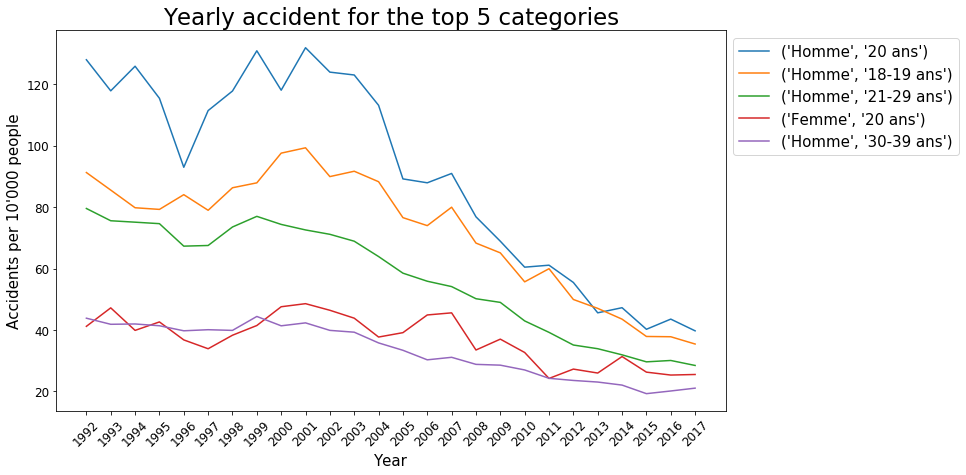

Number of accident for different sexe and age for 1/10.000 inhabitants in Switzerland
for the interesting categories:


1992       2017
sexe  age                                  
Homme 20 ans          127.971524  39.736442
      18-19 ans        91.262445  35.445563
      21-29 ans        79.562532  28.468726
Femme 20 ans           41.204299  25.532472
Homme 30-39 ans        43.852580  21.087092
Femme 21-29 ans        30.755826  19.821769
Homme 70 ans et plus   27.131433  19.782825
      15-17 ans         4.312239   0.534870
      10-14 ans         2.423276   0.047569
      6-9 ans           0.062282   0.000000
Femme 10-14 ans         0.746233   0.000000
      15-17 ans         1.575920   0.000000

In [16]:
# We only consider the private vehicles accidents where there was a mistake from the driver
df_conducteur = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                        & (df_Accident_objets_normalized.voiture_index==210)]

# Group by sex and age as wanted, sum the number of accidents and sort them to see which 
# category had the biggest impact in 2017, and keep the columns interesting us, i.e. the years
df_conducteur = df_conducteur.groupby(['sexe','age']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_conducteur.columns if IS_DATE.match(col)]]

# Plot the top 5 categories with our homemade function
plot_dataframe(x=df_conducteur.columns.values, y=df_conducteur.head(5),\
               title='Yearly accident for the top 5 categories', xlabel='Year',\
               ylabel="Accidents per 10'000 people", labels=df_conducteur.index.values,\
               rotation=45, number_to_plot=None)

print("Number of accident for different sexe and age for 1/10.000 inhabitants in Switzerland\n\
for the interesting categories:")
display(df_conducteur.loc[[('Homme', '20 ans'), ('Homme', '18-19 ans'),
       ('Homme', '21-29 ans'), ('Femme', '20 ans'),
       ('Homme', '30-39 ans'), ('Femme', '21-29 ans'),
       ('Homme', '70 ans et plus'),
       ('Homme', '15-17 ans'), ('Homme', '10-14 ans'),
       ('Homme', '6-9 ans'), ('Femme', '10-14 ans'),
       ('Femme', '15-17 ans')],['1992', '2017']])

As expected, young people are still the ones to have the most accidents in 2017. Men are in particular responsible of more incidents than women, except apparently between 21 and 29 years old, which is the only time we find them having more accidents than men of the same age interval. After the young people, we actually find the very old ones, with men that are 70 years old and more. But they still have half less accidents than young men aged 20.

We can interestingly see that more than 1 in 20'000 men is involved in an accident before 18 years old ! Back 25 years ago, some boys even younger than 10 years old were involved in car incidents.

If we now compare the records of 2017 with the ones from 1992, we see a drastical decrease, which was to be expected with the numerous improvements observed around the security of travelers, including the improvements of the cars themselves, but also the stricter rules of today. The decrease is more marked for young people, the number of accidents dropped of 2/3 for men aged 20!

Nicely, we can see that women did not have any accident before the legal age to drive a car in Switzerland, i.e. 18 years old, in 2017, which wasn't the case 25 years earlier.

From the first plot, we can identify a very good progress since the early 2000's for the entire population.

##### Taking the number of people actually posessing a driver license into account

Now that we know the accidents for each age & sex category, it is interesting to take into account the fact that not every man-woman posesses a driver license. However, we are confronted to the usual problem: the dataset containing this new information is built differently, as can be seen below. The age categories are different, and not all the years are represented.

In [17]:
df_proportion_permis

,critere,1994,2000,2005,2010,2015
0,Total,76.1925,79.5684,81.4970,80.8099,81.5869
1,Hommes,86.7108,88.6161,89.1752,87.8091,87.9242
2,Femmes,66.2318,71.0744,74.4214,74.4154,75.5780
3,18-24 ans,70.7393,68.7840,62.7032,58.6586,60.9546
4,25-64 ans,84.8314,87.8657,89.5716,89.3944,88.8073
5,65 ans et plus,44.2482,53.2861,61.7433,64.0817,69.2718


In general, we can note an increase in the proportion of people with a driver license. 

An interesting conclusion comes from the fact that not that many young people posess a license, and yet they are responsible for a lot of accidents. Sadly, since the age intervals are not defined like before and are very vague, we cannot really perform an analysis on them. However, it is to notice that if we did, we would see an even greater gap between younger and older people: young people have more accidents per 10'000 people but less have a driver license. This means that they will have even more accidents per 10'000 people posessing a license!

Given the lack of information of this dataset again (the information on the sexes is aggregated and only present for a few years), we can only restrain our analysis on the accidents by sexes for the 5 years in the data.

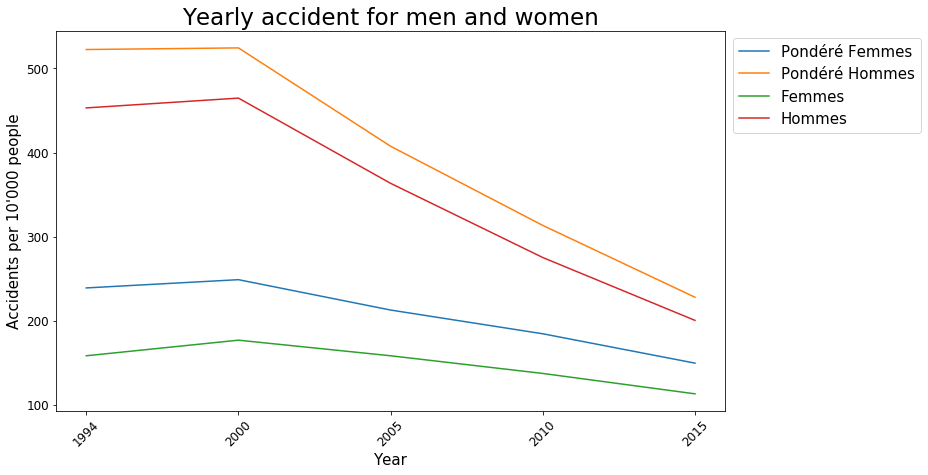

In [18]:
# Get the total accident for men and women for the years interesting us
df_conducteur_sexe = df_conducteur.groupby('sexe').sum()\
    [['1994', '2000', '2005', '2010', '2015']]

# Make the indices plural to match the ones of the other dataset
df_conducteur_sexe = df_conducteur_sexe.transpose().add_suffix('s').transpose()

# Get the proportion of men and women having a license
df_proportion_sexe = df_proportion_permis.iloc[1:3].set_index('critere')

# Scale the data given the proportion of people with a license
df_conducteur_sexe_scaled = df_conducteur_sexe/df_proportion_sexe*100

# Custom the indices
df_conducteur_sexe_scaled = df_conducteur_sexe_scaled.transpose().add_prefix('Pondéré ').transpose()

# Concatenate the dataframes to plot them
df_conducteur_sexe_scaled = df_conducteur_sexe_scaled.append(df_conducteur_sexe)

# plot the results with our function
plot_dataframe(x=df_conducteur_sexe_scaled.columns.values, y=df_conducteur_sexe_scaled,\
               title='Yearly accident for men and women', xlabel='Year',\
               ylabel="Accidents per 10'000 people",\
               labels=df_conducteur_sexe_scaled.index.values,\
               rotation=45, number_to_plot=None)

Since the proportion of women having a license hase always been below the one for men, the impact is higher for them. However, even with this scaling, we can still say that women are more cautious with cars with 150 accidents for 10'000 drivers in 2017 against 228 for men. But the gap was still reduced over the last years and men might catch up one day.

#### 1.1.2. Driver Licence

How long had the people in an accident had their license for? In this analysis, we start again from the normalized total of accidents that we created before.

In [26]:
df_Accident_objets['annee_permis'].unique()

array(['0 an', '1 an', '2 ans', '3 ans', '4 ans', '5 ans', '6-10 ans',
       '11-15 ans', '16 ans et plus', 'Inconnu'], dtype=object)

In [19]:
mapping={}
index_permis = df_Accident_objets['annee_permis_index'].unique()
for i in range(len(index_permis)):
    if ((index_permis[i]==999) | (index_permis[i] == 16)):
        mapping[index_permis[i]] = 1
    else:
        mapping[index_permis[i]] = index_permis[i+1] - index_permis[i]


df_permis = df_Accident_objets_normalized.copy()

df_permis = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                            & (df_Accident_objets_normalized.voiture_index==210)]
df_permis = df_permis.groupby(['annee_permis','annee_permis_index']).sum().sort_values(['2017'], ascending=False)
dates = [col for col in df_permis.columns if IS_DATE.match(col)]

for i in range(len(df_permis.index)):
    df_permis.loc[df_permis.index.values[i]] = df_permis.loc[df_permis.index.values[i]] / mapping[df_permis.index.values[i][1]]
df_permis = df_permis[[col for col in df_permis.columns if IS_DATE.match(col)]].sort_values(['2017'], ascending=False)
display(df_permis)

,,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
annee_permis,annee_permis_index,,,,,,,,,,,,,,,,,,,,,
16 ans et plus,16.0,151.830988,155.492622,157.363385,159.403876,150.194756,156.738364,155.433811,160.281814,173.458723,170.031310,...,139.520963,138.460565,132.426681,124.912390,119.172723,115.470413,114.408562,112.456571,114.792466,110.276788
0 an,0.0,142.498262,123.374769,123.556499,128.246876,134.726054,128.560318,138.590490,148.358898,156.150508,158.154178,...,103.349804,107.369984,91.846562,90.650620,82.193101,73.991970,73.751087,66.297358,66.413550,65.903547
1 an,1.0,115.056016,116.987970,105.379789,103.902797,91.447105,92.487221,105.406004,114.483530,107.449539,121.968624,...,75.841267,69.190132,60.503807,59.967035,59.746205,53.247396,52.533768,43.266116,47.139497,45.323683
2 ans,2.0,60.729267,61.781925,67.446199,53.471419,37.813390,45.859647,53.980696,55.626946,53.101017,57.694045,...,42.361811,39.063671,36.455055,30.937408,28.064216,28.548895,27.969970,26.389337,26.583125,24.397839
3 ans,3.0,21.661587,19.040298,19.630905,18.491277,15.035516,15.244564,15.719121,18.181270,17.416233,17.423118,...,12.650185,12.532685,9.571983,9.519724,9.023592,8.480907,8.390982,7.787504,6.928320,7.404767
4 ans,4.0,16.808797,16.995324,17.814826,16.588059,14.531135,15.446187,13.960276,15.545337,15.618946,15.944966,...,11.496095,9.942998,9.450254,8.815974,7.130637,8.006289,6.830234,6.806711,6.956656,6.384212
5 ans,5.0,14.839632,14.184733,15.103948,15.069014,14.938232,13.351162,12.610990,13.472996,12.903029,13.612848,...,9.823983,8.726848,8.875188,7.341964,6.291182,6.063323,6.058009,5.565988,6.087784,5.788939
6-10 ans,6.0,11.842954,11.878440,11.847788,12.109018,11.073046,11.179562,11.864094,12.247334,11.829183,11.006537,...,7.497953,6.917013,6.878061,6.050665,5.474215,5.459698,5.257620,4.839923,4.767883,4.883310
11-15 ans,11.0,7.140738,7.221523,7.627887,7.237492,6.932951,6.924922,7.010503,7.381686,7.136687,7.308612,...,4.576432,4.696056,4.416956,4.137954,4.084221,3.905022,3.713235,3.447830,3.455713,3.446991


In [20]:
# Excluding young drivers (driver licence > 4 years)
df_conducteur_confirmed = df_Accident_objets_normalized_licence[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized_licence.voiture_index==210)\
                                            &(df_Accident_objets_normalized_licence.annee_permis_index>4)\
                                             &(df_Accident_objets_normalized_licence.annee_permis_index!=999)]
df_conducteur_confirmed = df_conducteur_confirmed.groupby(['age']).sum().sort_values(['2015'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_confirmed.head(10))

NameError: name 'df_Accident_objets_normalized_licence' is not defined

In [21]:
# Âge and driver licence
df_conducteur_confirmed = df_Accident_objets_normalized_licence[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized_licence.voiture_index==210)\
                                             &(df_Accident_objets_normalized_licence.annee_permis_index!=999)]
df_conducteur_confirmed = df_conducteur_confirmed.groupby(['annee_permis','age']).sum().sort_values(['2015'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_confirmed.head(10))

NameError: name 'df_Accident_objets_normalized_licence' is not defined

In [22]:
# Without driver licence
df_conducteur_illegal = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                             &(df_Accident_objets_normalized.annee_permis_index==999)]
df_conducteur_illegal = df_conducteur_illegal.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_illegal.head(5))

1992      1993      1994      1995      1996      1997  \
sexe  age                                                                     
Homme 15-17 ans  1.824409  1.498339  1.408392  1.471093  1.528806  1.111588   
      21-29 ans  1.641859  1.309747  1.103872  1.056379  0.901198  1.030963   
      18-19 ans  2.045734  1.640651  2.043097  1.582837  1.461846  1.703578   
      30-39 ans  0.508080  0.447786  0.556733  0.497510  0.542556  0.362207   
Femme 18-19 ans  0.238889  0.000000  0.000000  0.632767  0.127717  0.128182   

                     1998      1999      2000      2001    ...         2008  \
sexe  age                                                  ...                
Homme 15-17 ans  1.419111  1.567521  1.867966  1.484514    ...     1.419930   
      21-29 ans  1.086975  1.399989  1.370114  1.296046    ...     1.036269   
      18-19 ans  1.685224  1.292734  1.851959  1.854084    ...     2.541431   
      30-39 ans  0.296653  0.561230  0.612855  0.425086    ...     0.517630   
Femme 18-19 ans  0.252433  0.247522  0.000000  0.363372    ...     0.111323   

                     2009      2010      2011      2012      2013      2014  \
sexe  age                                                                     
Homme 15-17 ans  1.148493  1.033928  1.109287  1.487144  0.671296  0.451169   
      21-29 ans  1.238738  0.757157  0.806777  0.694277  0.766359  0.698850   
      18-19 ans  2.087029  1.640857  0.831367  1.267146  1.062101  0.632544   
      30-39 ans  0.286210  0.481973  0.335386  0.417869  0.256913  0.218783   
Femme 18-19 ans  0.000000  0.107444  0.000000  0.223020  0.223614  0.000000   

                     2015      2016      2017  
sexe  age                                      
Homme 15-17 ans  0.593331  0.525782  0.534870  
      21-29 ans  0.393952  0.335019  0.355119  
      18-19 ans  0.206569  1.354294  0.318373  
      30-39 ans  0.247978  0.228742  0.258539  
Femme 18-19 ans  0.111356  0.000000  0.228849  

[5 rows x 26 columns]

### 1.2. Where?

#### 1.2.1. Road type

In this section, we will analyze on which tpe of road the accidents happended. They are separated in three categories, i.e. accidents in localities, out of them or on the highway.

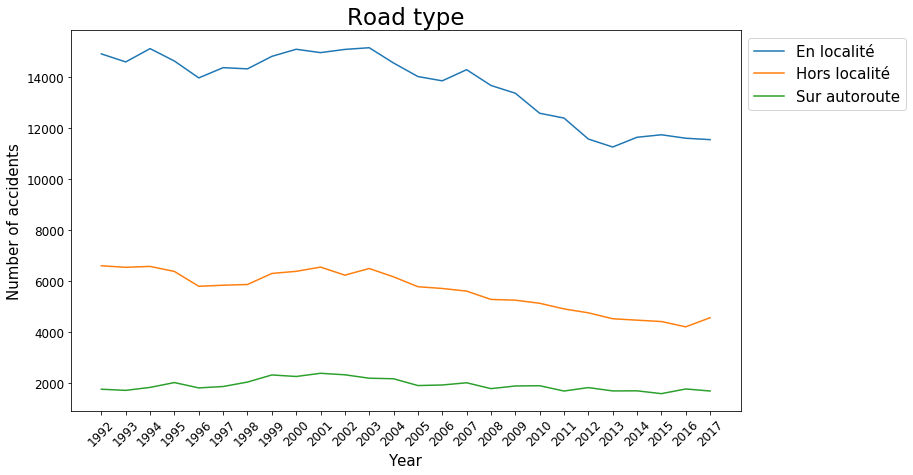

In [169]:
# Get the 'rurality' of the accidents by summing all the accidents by type of road
# Keep the interesting columns, i.e. the different years
req = df_Accident_type_route.groupby(['ruralite']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

# Plot the accidents by road type with our function
plot_dataframe(x=req.columns.values, y=req, title='Road type', xlabel='Year',\
               ylabel='Number of accidents', labels=req.index.values,\
               rotation=45, number_to_plot=None)

In general, we can see a decrease of the number of accidents throughout the years. This tenency was also observed above. It is less marked here but one must remember that the data is not normalized here: the number of people on the roads increased while the number of incidents still decreased.

We are in particular interested in the amount of accidents leading to deaths. Below, we analyze the proportion of incidents (in %) with tragic consequences.

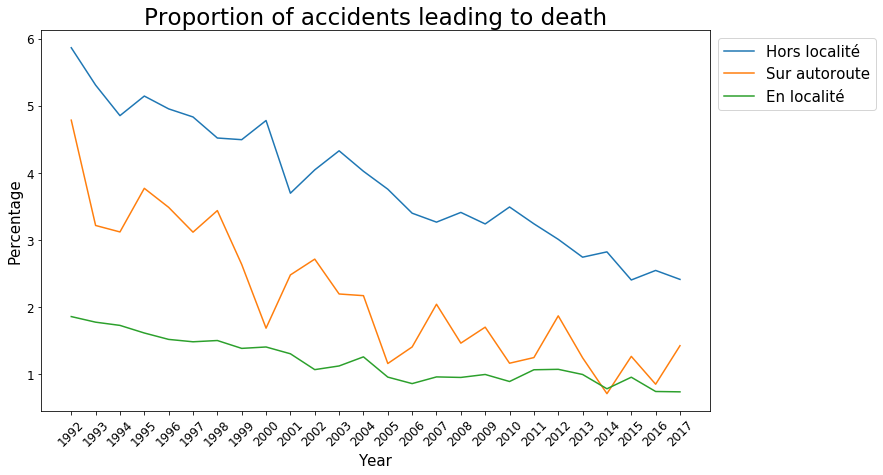

In [170]:
# Get the yearly total of accidents on each road type
total_accident = df_Accident_type_route.groupby(['ruralite']).sum()\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

df_Accident_type_route_normalized_ruralite = df_Accident_type_route.copy()

# Get the percentage of each category of accidents for each year and road type
for ruralite in total_accident.index.values:
    for year in total_accident.columns:
        df_Accident_type_route_normalized_ruralite.\
        loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite,year]=\
            df_Accident_type_route_normalized_ruralite.\
            loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite][year]*100/\
            total_accident.loc[total_accident.index==ruralite,year][0]

# We are interested in the deadly accidents on a yearly basis, grouped by the different
# road types.
req = df_Accident_type_route_normalized_ruralite\
        [df_Accident_type_route_normalized_ruralite.gravite_index==317].\
        groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]

# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title='Proportion of accidents leading to death', xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None)

We can see the proportion of deadly accidents has been dropping during the last 25 years. This corroborates our previous affirmation: the securtiy of the drivers has been seriously improved.

We can also take a look at the conditions and the speed limit of the roads on which the accidents happened.

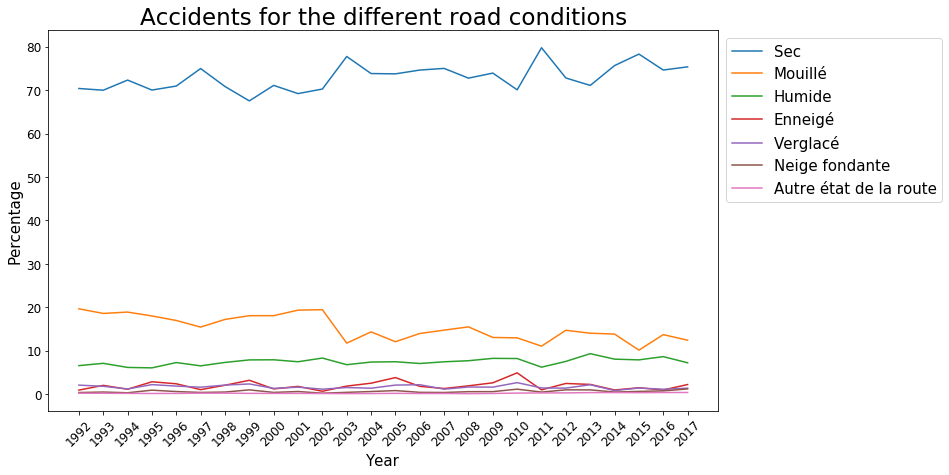

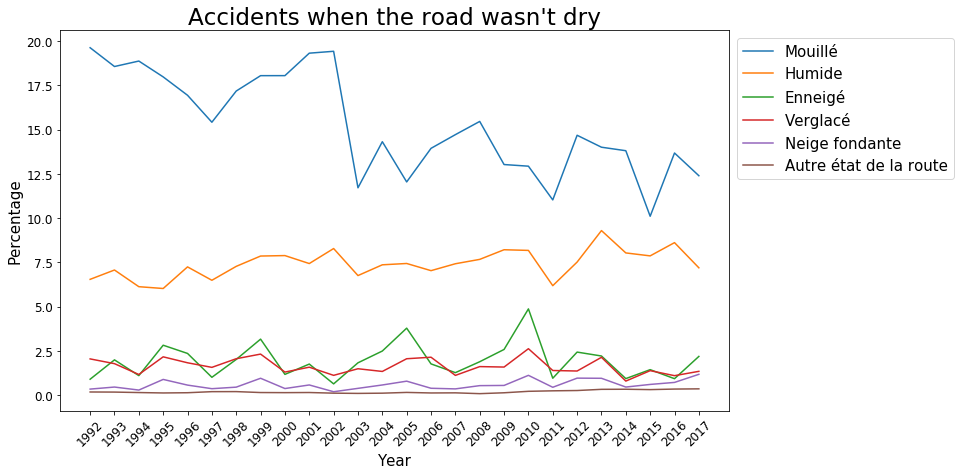

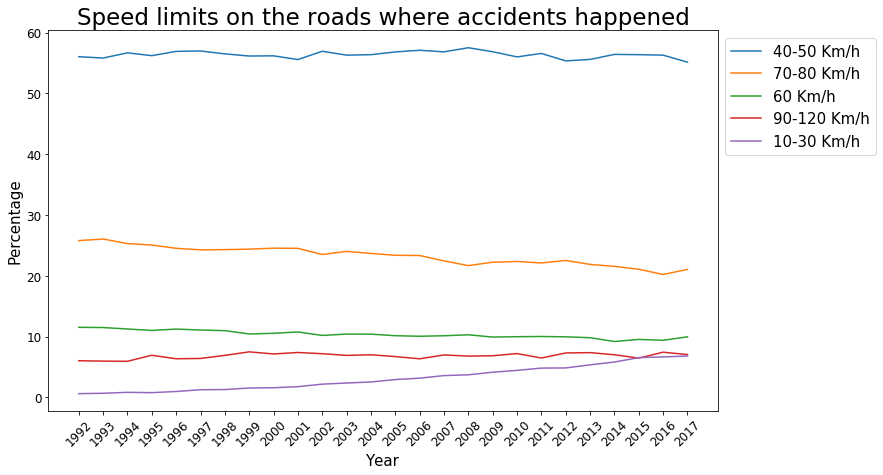

In [174]:
df_Accident_type_route_normalized = df_Accident_type_route.copy()

# Transform the data in percentages along the year
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date]=\
        df_Accident_type_route_normalized[date]*100/\
        (df_Accident_type_route_normalized[date].sum())

# Group the accidents by road condition and keep the useful columns
req = df_Accident_type_route_normalized.groupby(['temps']).sum().\
    sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title='Accidents for the different road conditions', xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None)

# This time without considering the accidents happening when the road is dry
req = df_Accident_type_route_normalized[df_Accident_type_route_normalized.temps!='Sec'].\
    groupby(['temps']).sum().sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# Plot the results with our function
plot_dataframe(x=req.columns.values, y=req,\
               title="Accidents when the road wasn't dry", xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None)

# We can also look at the speed limits of the roads where accidents happened
req = df_Accident_type_route_normalized.groupby(['vitesse']).sum().\
    sort_values(['2017'], ascending=False)\
    [[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
# And plot it with our usual function
plot_dataframe(x=req.columns.values, y=req,\
               title="Speed limits on the roads where accidents happened", xlabel='Year',\
               ylabel='Percentage', labels=req.index.values,\
               rotation=45, number_to_plot=None)

We can see that the vast majority of the accidents are happening on dry roads. This might be unexpected and point towards the fact that the people are less careful when the conditions seem ideal. If the road is not dry, then most incidents happen in wet or damp conditions, which is not very surprising.

Most of the incidents happened on roads limited at between 40 and 50 km/h, i.e. inside localities. They are probably not the deadliest ones but are surely numerous due to the high number of external factors that can impact the driver and cause an accident. We can see an increase in accidents on roads limited below 30 km/h, which might be due to the growing number of those roads appearing in the cities.

#### 1.2.2. Cantons

This part describes the main dataset that we plan to use in the scope of a 'canton-scale comparative study'. Since we have an **aggregated** dataset of car accidents in cantons, the possibility of correlations within the dataset are limited. 

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
canton,,,,,,,,,,,,,,,,,,,,,
Zürich,3102.0,2960.0,3135.0,3081.0,2922.0,3102.0,3097.0,3283.0,3367.0,3400.0,...,3115.0,3225.0,3034.0,3012.0,2940.0,2835.0,3044.0,3202.0,3410.0,3352.0
Bern / Berne,3237.0,3176.0,3234.0,3176.0,3019.0,3058.0,3018.0,3107.0,3053.0,3155.0,...,2732.0,2534.0,2561.0,2630.0,2596.0,2462.0,2509.0,2551.0,2465.0,2616.0
Vaud,2725.0,2620.0,2670.0,2602.0,2349.0,2319.0,2422.0,2573.0,2717.0,2538.0,...,2043.0,2032.0,1981.0,1802.0,1758.0,1782.0,1609.0,1400.0,1692.0,1646.0
Aargau,1547.0,1531.0,1691.0,1576.0,1544.0,1484.0,1431.0,1722.0,1686.0,1708.0,...,1408.0,1464.0,1345.0,1358.0,1250.0,1191.0,1215.0,1213.0,1079.0,1155.0
Genève,1122.0,1084.0,1125.0,1039.0,1033.0,1039.0,1167.0,1222.0,1256.0,1359.0,...,1238.0,1142.0,1108.0,918.0,1023.0,1181.0,1300.0,1264.0,1170.0,1127.0


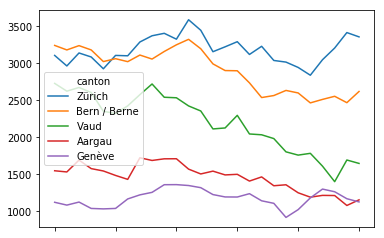

In [25]:
req = df_Accident_cantons.groupby(['canton']).sum().sort_values(['2017'], ascending=False).head(5)[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [26]:
# Normalized with the road lentgh
df_Longueur_routes_cantonindex = df_Longueur_routes.copy()
for elem in df_Longueur_routes_cantonindex['canton'].unique():
    try:
        getKeysByValue(dict_cantons, elem)
    except:
        df_Longueur_routes_cantonindex = df_Longueur_routes_cantonindex[df_Longueur_routes_cantonindex.canton!=elem]
df_Longueur_routes_cantonindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Longueur_routes_cantonindex['canton']]

df_Accident_cantonsindex = df_Accident_cantons.copy()
df_Accident_cantonsindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Accident_cantonsindex['canton']]

df_Accident_cantonsindex_normalizedkm = df_Accident_cantonsindex.copy().drop(['2017'],axis=1)

for canton in df_Accident_cantonsindex_normalizedkm.canton.unique():
    for date in [d for d in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(d)]:
        df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]=\
        100*df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]/\
        df_Longueur_routes_cantonindex[(df_Longueur_routes_cantonindex.canton == canton) \
                                       & (df_Longueur_routes_cantonindex.annee==int(date))]['Total'].values[0]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
BS,195.356285,209.866667,230.400000,228.983187,209.500934,218.666667,193.333333,196.266667,175.205734,160.339793,...,141.255007,131.824234,125.699068,101.329787,84.308511,68.085106,86.968085,99.600533,104.127830,109.986684
GE,81.802275,78.556417,83.031958,76.684626,76.241789,76.498307,85.922545,89.972022,92.475335,100.058901,...,87.836843,91.150052,84.081873,81.590574,67.599411,75.331370,86.966127,95.714917,93.132921,86.206897
ZG,53.888011,54.405054,44.408775,57.963260,50.835279,54.787138,57.481588,54.966768,55.864918,57.481588,...,60.573283,61.294393,62.556337,60.180180,56.576577,50.270270,45.765766,49.667087,48.047508,48.407414
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290


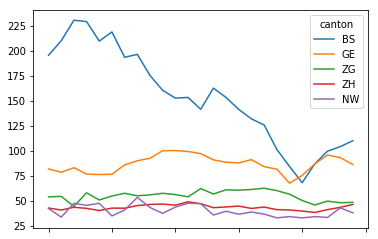

In [27]:
req = df_Accident_cantonsindex_normalizedkm.groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
GE,81.802275,78.556417,83.031958,76.684626,76.241789,76.498307,85.922545,89.972022,92.475335,100.058901,...,87.836843,91.150052,84.081873,81.590574,67.599411,75.331370,86.966127,95.714917,93.132921,86.206897
ZG,53.888011,54.405054,44.408775,57.963260,50.835279,54.787138,57.481588,54.966768,55.864918,57.481588,...,60.573283,61.294393,62.556337,60.180180,56.576577,50.270270,45.765766,49.667087,48.047508,48.407414
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290
SZ,46.809947,42.069741,46.681665,52.548667,44.671993,45.781777,45.781777,47.469066,43.771802,44.671993,...,40.283560,41.183752,39.158321,40.269966,36.895388,35.195531,32.625698,30.188259,33.195945,33.084549


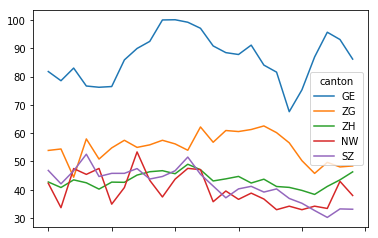

In [28]:
#BS is an outlier
req = df_Accident_cantonsindex_normalizedkm[df_Accident_cantonsindex_normalizedkm.canton!='BS'].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
ZH,42.728450,40.771350,43.470423,42.439186,40.200314,42.676719,42.607930,45.166882,46.354425,46.725119,...,44.698587,42.359628,43.715773,41.127830,40.813008,39.745843,38.326349,41.151818,43.481803,46.306355
NW,42.247744,33.634126,47.478992,45.416316,47.518923,34.873950,40.756303,53.361345,43.313709,37.426409,...,36.585366,38.782319,36.697248,32.916667,34.166667,32.916667,34.166667,33.361134,42.952460,37.948290
SZ,46.809947,42.069741,46.681665,52.548667,44.671993,45.781777,45.781777,47.469066,43.771802,44.671993,...,40.283560,41.183752,39.158321,40.269966,36.895388,35.195531,32.625698,30.188259,33.195945,33.084549
SG,45.045045,45.379651,46.306467,43.354387,40.470960,41.638061,43.615200,48.955837,47.993975,49.226875,...,47.853096,43.654857,44.845013,40.801887,42.183288,40.768194,33.018868,32.740501,30.685799,29.506871
UR,36.363636,38.534600,44.233379,49.932157,45.047490,44.776119,43.419267,42.333786,42.876526,43.184885,...,34.278003,31.039136,40.215924,29.380054,28.301887,28.571429,33.153639,25.371120,31.578947,27.530364
LU,34.205231,32.750348,32.719393,33.400402,32.007429,35.350565,32.704782,36.084869,36.766300,40.663257,...,34.226421,35.068747,35.686699,33.827618,34.166667,31.820988,29.845679,31.177651,31.270258,26.392962
SO,30.703335,31.127314,32.569506,32.009935,28.844998,31.768288,30.245974,34.212002,36.496935,35.415248,...,38.524557,33.722231,33.682276,33.799441,31.482221,27.127447,24.770276,23.413777,24.492568,25.251718


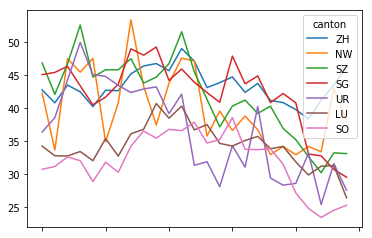

In [29]:
#BS, GE, ZG are an outlier
req = df_Accident_cantonsindex_normalizedkm[(df_Accident_cantonsindex_normalizedkm.canton.isin(['BS','GE','ZG']))==False].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(7)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

### 1.3. When?

We will then analyze the different circumstances leading to accidents.

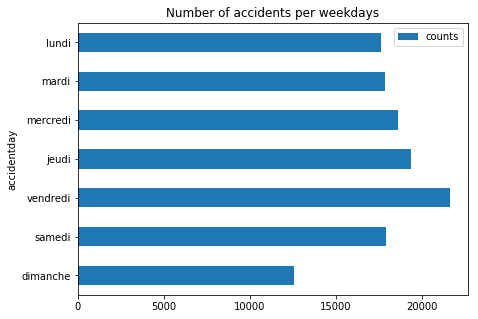

In [47]:
new_df_day = df_hacked_accident[['accidentday', 'canton', 'id']]
accidents_day_count = new_df_day.groupby('accidentday')[['id']].count().reindex(['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche'])
accidents_day = accidents_day_count.rename(columns = {'id' : 'counts'})

accidents_day[::-1].plot(kind='barh', figsize=(7,5), title='Number of accidents per weekdays')
plt.show()

count_day_canton = new_df_day.groupby(['accidentday', 'canton']).count()
count_day_canton_reset = count_day_canton.reset_index()
table_day_canton = count_day_canton_reset.pivot(index='canton', columns='accidentday', values='id')
table_day_canton_sort = table_day_canton.reindex(columns = accidents_day.index)
#table_day_canton_sort

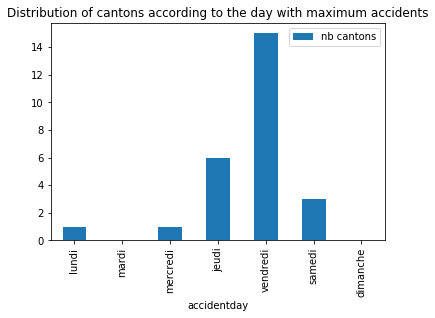

In [48]:
worst_day_canton = table_day_canton_sort.idxmax('columns')
df_worst_day = worst_day_canton.to_frame()
worst_day_reset = df_worst_day.reset_index()
worst_day_reset.columns = ['canton', 'day']
worst_day = worst_day_reset.groupby(['day']).count()

d = {'canton' : pd.Series([0, 0], index=['mardi', 'dimanche'])}
df2 = pd.DataFrame(d)
worst_day_distrib = worst_day.append(df2).reindex(accidents_day.index).rename(columns = {'canton' : 'nb cantons'})
worst_day_distrib.plot(kind='bar', title='Distribution of cantons according to the day with maximum accidents')
plt.show()

In [50]:
new_df_hour = df_hacked_accident[['accidentday', 'accidenthour', 'id']]
count_day_hour = new_df_hour.groupby(['accidentday', 'accidenthour']).count()
count_day_hour_reset = count_day_hour.reset_index()
table_day_hour = count_day_hour_reset.pivot(index='accidenthour', columns='accidentday', values='id')
table_day_hour_sort = table_day_hour.reindex(columns = accidents_day.index).dropna(axis=0)
#table_day_hour_sort

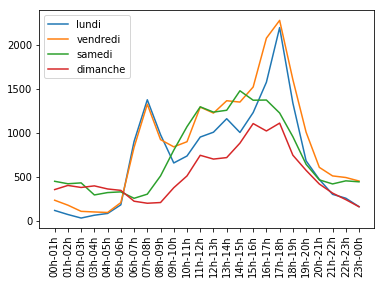

In [51]:
plt.figure()
plt.plot(table_day_hour_sort.index, table_day_hour_sort.lundi)
plt.plot(table_day_hour_sort.index, table_day_hour_sort.vendredi)
plt.plot(table_day_hour_sort.index, table_day_hour_sort.samedi)
plt.plot(table_day_hour_sort.index, table_day_hour_sort.dimanche)
plt.legend(['lundi','vendredi','samedi', 'dimanche'])
plt.xticks(rotation=90)
plt.show()

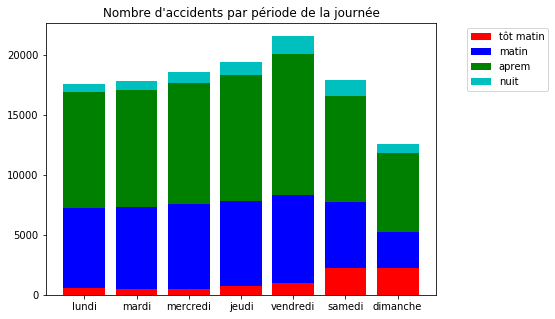

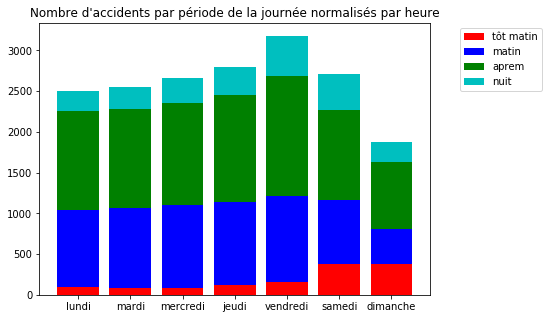

In [52]:
period = []
for i in range(24):
    if (i<6):
        time='tôt matin'
    elif i<13:
        time='matin'
    elif i<21:
        time='aprem'
    else:
        time='nuit'
    period.append(time)

table_day_hour_sort['period']=period

stack_data = table_day_hour_sort.groupby('period').sum().reindex(['tôt matin','matin','aprem','nuit'])
stack_data_mn = table_day_hour_sort.groupby('period').mean().reindex(['tôt matin','matin','aprem','nuit'])

plt.figure(figsize = (7,5))
plt.bar(stack_data.columns, stack_data.iloc[0], color='r')
plt.bar(stack_data.columns, stack_data.iloc[1], bottom=stack_data.iloc[0], color='b')
plt.bar(stack_data.columns, stack_data.iloc[2], bottom=np.array(stack_data.iloc[0])\
                                                 +np.array(stack_data.iloc[1]), color='g')
plt.bar(stack_data.columns, stack_data.iloc[3], bottom=np.array(stack_data.iloc[0])\
                                                 +np.array(stack_data.iloc[1])+np.array(stack_data.iloc[2]), color='c')
plt.legend(['tôt matin','matin','aprem','nuit'], bbox_to_anchor=(1.3, 1))
plt.title("Nombre d'accidents par période de la journée")

plt.figure(figsize = (7,5))
plt.bar(stack_data_mn.columns, stack_data_mn.iloc[0], color='r')
plt.bar(stack_data_mn.columns, stack_data_mn.iloc[1], bottom=stack_data_mn.iloc[0], color='b')
plt.bar(stack_data_mn.columns, stack_data_mn.iloc[2], bottom=np.array(stack_data_mn.iloc[0])\
                                                 +np.array(stack_data_mn.iloc[1]), color='g')
plt.bar(stack_data_mn.columns, stack_data_mn.iloc[3], bottom=np.array(stack_data_mn.iloc[0])\
                                                 +np.array(stack_data_mn.iloc[1])+np.array(stack_data_mn.iloc[2]), color='c')
plt.legend(['tôt matin','matin','aprem','nuit'], bbox_to_anchor=(1.3, 1))
plt.title("Nombre d'accidents par période de la journée normalisés par heure")

plt.show()

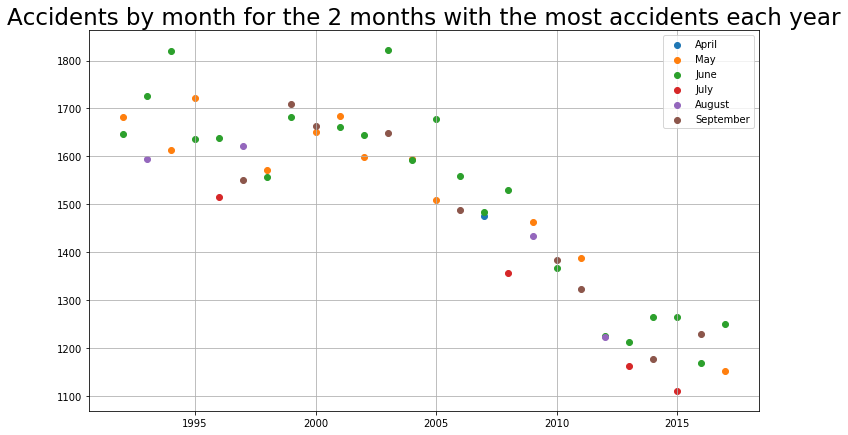

In [42]:
months_to_plot = 2

monthly_basis = df_Accident_circonstances.groupby('mois_index').sum().reset_index().apply(lambda x: x.nlargest(months_to_plot))
period = np.arange(1992,2018,1)

plt.figure(figsize=(12,7))

for month in range(monthly_basis.shape[0]):
    to_plot = monthly_basis.iloc[month].values[6:]
    if len(to_plot[np.isnan(to_plot)==False]) != 0:
        plt.scatter(period,monthly_basis.iloc[month].values[6:], label=datetime.date(1900, int(monthly_basis.index[month]+1), 1).strftime('%B'))

plt.title('Accidents by month for the {} months with the most accidents each year'.format(months_to_plot), fontsize=23)
plt.legend()
plt.grid()
plt.show()

> This dataset might provide some relevant outcomes regarding the decision makers (drivers and/or walkers)

### 1.4. What? (victims)

We will take a look at the different victims of accidents.

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
gravite,,,,,,,,,,,,,,,,,,,,,
Accidents mortels,3.214163,2.892526,2.707528,2.778984,2.604505,2.505096,2.473911,2.34275,2.338122,2.075661,...,1.62037,1.633668,1.596206,1.64297,1.658585,1.470841,1.2863,1.341903,1.183365,1.230406


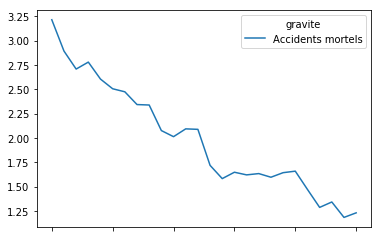

In [58]:
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())
    req = df_Accident_type_route_normalized[df_Accident_type_route_normalized.gravite_index==317].groupby(['gravite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

> One more time, since decision makers want to minimize the number of victims, some outcoming correlations between the vehicle type and the accidents for example might be useful in our study. 

### 1.5. Why?

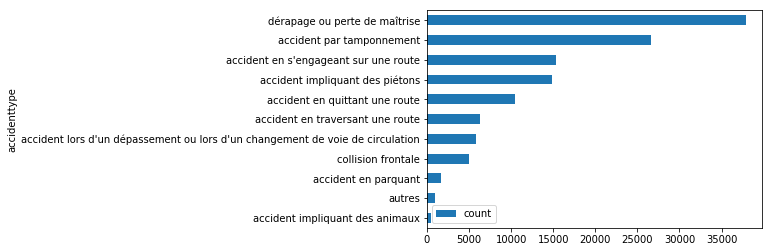

In [56]:
# plot bars of sorted accidents per months and per type
new_df_hack = df_hacked_accident[['accidentmonth', 'accidenttype', 'id']]
count_type = new_df_hack.groupby(['accidenttype'])[['id']].count()
count_type_sort = count_type.sort_values(['id'], ascending=True).rename(columns = {'id' : 'count'})
count_type_sort.plot(kind='barh')
plt.show()

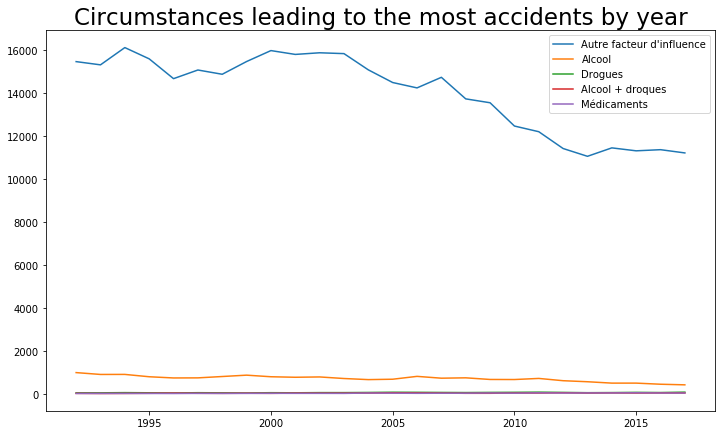

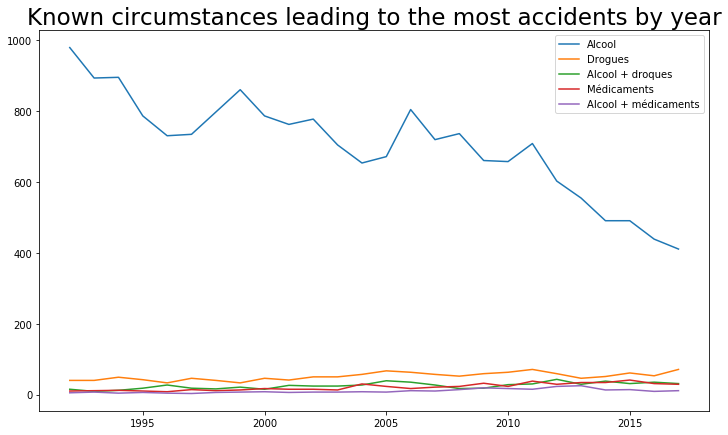

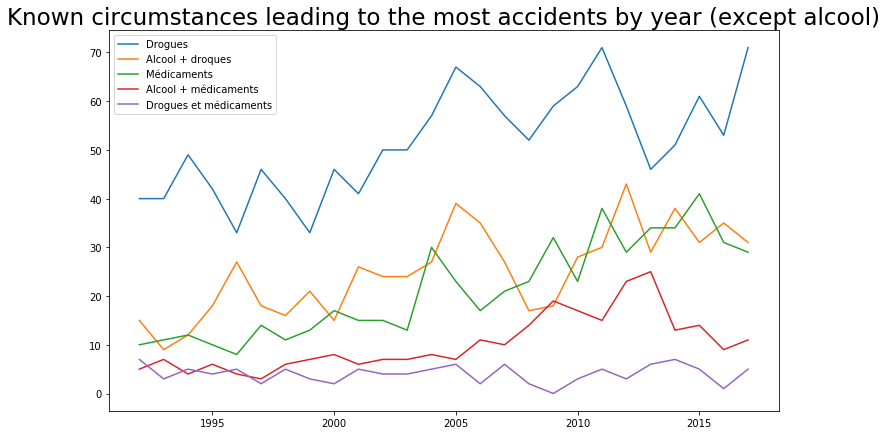

In [57]:
df_Accident_circonstances.circonstance.unique()

months_to_plot = 5

monthly_basis = df_Accident_circonstances.groupby('circonstance').sum().reset_index()
monthly_basis_temp = monthly_basis
monthly_basis_temp['temp'] = 1
monthly_basis_temp = monthly_basis_temp.groupby('temp').apply(lambda x: x.nlargest(months_to_plot,'2017'))

period = np.arange(1992,2018,1)

plt.figure(figsize=(12,7))
for circ in monthly_basis_temp['circonstance']:
    plt.plot(period, monthly_basis[monthly_basis['circonstance']==circ].values[0][7:-1], label=circ)

plt.title('Circumstances leading to the most accidents by year', fontsize=23)
plt.legend()
plt.show()


monthly_basis = df_Accident_circonstances.groupby('circonstance').sum().reset_index()
monthly_basis_temp = monthly_basis
monthly_basis_temp['temp'] = 1
monthly_basis_temp = monthly_basis_temp.groupby('temp').apply(lambda x: x.nlargest(months_to_plot+1,'2017'))

period = np.arange(1992,2018,1)

plt.figure(figsize=(12,7))
for circ in monthly_basis_temp['circonstance']:
    if circ != "Autre facteur d'influence":
        plt.plot(period, monthly_basis[monthly_basis['circonstance']==circ].values[0][7:-1], label=circ)

plt.title('Known circumstances leading to the most accidents by year', fontsize=23)
plt.legend()
plt.show()


monthly_basis = df_Accident_circonstances.groupby('circonstance').sum().reset_index()
monthly_basis_temp = monthly_basis
monthly_basis_temp['temp'] = 1
monthly_basis_temp = monthly_basis_temp.groupby('temp').apply(lambda x: x.nlargest(months_to_plot+2,'2017'))

period = np.arange(1992,2018,1)

plt.figure(figsize=(12,7))
for circ in monthly_basis_temp['circonstance']:
    if (circ != "Autre facteur d'influence") & (circ != "Alcool"):
        plt.plot(period, monthly_basis[monthly_basis['circonstance']==circ].values[0][7:-1], label=circ)

plt.title('Known circumstances leading to the most accidents by year (except alcool)', fontsize=23)
plt.legend()
plt.show()

In [59]:
req = df_Accident_victimes.groupby(['consequence','role']).sum()
req = req[[col for col in req.columns if IS_DATE.match(col)]]
display(req)

1992     1993     1994     1995     1996     1997  \
consequence  role                                                               
Blessé grave Conducteur   5254.0   4866.0   4655.0   4627.0   4223.0   4258.0   
             Passager     1351.0   1142.0   1063.0   1153.0    904.0    953.0   
             Piéton       1239.0   1141.0   1022.0   1153.0   1050.0    955.0   
Blessé léger Conducteur  14214.0  14432.0  15480.0  14841.0  14084.0  14713.0   
             Passager     4929.0   4944.0   5314.0   5197.0   4619.0   4709.0   
             Piéton       1696.0   1685.0   1742.0   1788.0   1659.0   1697.0   
Tué          Conducteur    518.0    480.0    447.0    442.0    406.0    381.0   
             Passager      168.0    119.0    106.0    124.0    102.0     90.0   
             Piéton        148.0    124.0    126.0    126.0    108.0    116.0   

                            1998     1999     2000     2001   ...        2008  \
consequence  role                                             ...               
Blessé grave Conducteur   4316.0   4342.0   4355.0   4303.0   ...      3583.0   
             Passager      899.0    934.0    935.0    957.0   ...       559.0   
             Piéton        998.0   1023.0    901.0    934.0   ...       638.0   
Blessé léger Conducteur  14948.0  16117.0  16510.0  16875.0   ...     14944.0   
             Passager     4964.0   5327.0   5475.0   5422.0   ...      4115.0   
             Piéton       1665.0   1784.0   1882.0   1669.0   ...      1717.0   
Tué          Conducteur    377.0    366.0    376.0    374.0   ...       250.0   
             Passager       98.0    102.0     86.0     66.0   ...        48.0   
             Piéton        122.0    115.0    130.0    104.0   ...        59.0   

                            2009     2010     2011     2012     2013     2014  \
consequence  role                                                               
Blessé grave Conducteur   3487.0   3285.0   3278.0   3087.0   3013.0   3083.0   
             Passager      517.0    467.0    472.0    424.0    393.0    333.0   
             Piéton        704.0    706.0    687.0    691.0    723.0    627.0   
Blessé léger Conducteur  14818.0  14133.0  13617.0  12975.0  12411.0  12865.0   
             Passager     3848.0   3903.0   3497.0   3425.0   3269.0   2961.0   
             Piéton       1756.0   1743.0   1691.0   1616.0   1570.0   1652.0   
Tué          Conducteur    246.0    211.0    216.0    210.0    171.0    169.0   
             Passager       43.0     41.0     35.0     54.0     29.0     31.0   
             Piéton         60.0     75.0     69.0     75.0     69.0     43.0   

                            2015     2016     2017  
consequence  role                                   
Blessé grave Conducteur   2890.0   2847.0   2780.0  
             Passager      340.0    316.0    297.0  
             Piéton        600.0    622.0    577.0  
Blessé léger Conducteur  12937.0  12886.0  13199.0  
             Passager     3116.0   3049.0   2869.0  
             Piéton       1655.0   1672.0   1691.0  
Tué          Conducteur    168.0    145.0    156.0  
             Passager       27.0     21.0     27.0  
             Piéton         58.0     50.0     47.0  

[9 rows x 26 columns]

In [60]:
df_Accident_victimes_normalized = df_Accident_victimes.copy()
df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized['sexe_index']!=9]
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_victimes_normalized.loc[(df_Accident_victimes_normalized.age_index==age) &\
                                           (df_Accident_victimes_normalized.sexe==sexe),year]\
        = df_Accident_victimes_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized.age_index != 999]

In [61]:
# Piétons victimes
req = df_Accident_victimes_normalized[(df_Accident_victimes_normalized.role=='Piéton')].groupby(['age']).sum().sort_values(['2017'], ascending=False)
req = req[[col for col in req.columns if IS_DATE.match(col)]]
display(req)


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
age,,,,,,,,,,,,,,,,,,,,,
15-17 ans,7.717780,8.153087,7.792261,9.376233,8.715789,8.932902,9.223535,10.517108,9.303085,9.973122,...,11.330341,11.052824,12.913477,11.347898,10.490997,10.104480,11.469664,10.663410,12.492761,10.733823
20 ans,5.600790,7.898113,7.005661,8.342751,5.613772,5.905262,5.715608,8.608479,6.428816,5.586531,...,7.363378,8.817911,8.408998,7.914310,7.933559,8.813181,7.079945,7.782936,9.114062,9.837047
10-14 ans,10.698540,11.300038,10.661738,12.339314,9.480235,11.167718,9.981489,12.821000,12.047347,11.798442,...,9.949051,10.931326,10.905291,11.515187,10.210572,8.979034,10.561075,10.376726,9.616832,9.755883
6-9 ans,25.644259,24.516558,25.468372,23.693118,23.497910,19.134369,20.697450,22.423461,21.397723,19.055318,...,13.642684,15.405504,12.503387,13.267288,14.069588,12.402157,11.070708,10.268072,11.574144,9.501137
5 ans,22.415872,23.096274,22.537787,19.563683,18.247178,16.450908,17.982454,19.220450,18.799640,17.045335,...,10.418861,9.833508,11.308747,9.421829,8.196083,8.771100,6.865139,11.565835,8.887236,9.165600
18-19 ans,8.038923,3.978335,7.371992,8.442545,6.998848,7.969727,8.257829,9.985128,9.281402,9.643245,...,9.918601,9.415074,12.946619,10.849320,10.010515,11.448686,10.575685,8.721193,8.174401,8.374328
70 ans et +,21.011149,19.212145,17.245251,18.000441,17.810677,16.104889,16.424748,14.435817,13.973677,13.123510,...,10.050744,8.963426,9.399132,9.132925,8.698947,8.522635,7.624315,7.827630,6.634775,7.231812
21-29 ans,4.959789,4.531861,4.888104,4.947378,4.795929,5.150073,5.076271,4.978775,6.327050,5.157651,...,5.855399,6.390191,6.426025,5.739399,5.893728,5.241939,5.177619,4.600270,5.632205,5.001064
60-69 ans,8.349096,8.929607,7.872616,9.184371,8.030815,7.568384,7.057476,8.026585,6.960921,6.548321,...,4.883995,4.916165,4.348833,4.359093,3.343407,4.700686,4.415169,4.401211,3.842192,4.356173


In [62]:
# Piétons tués
req = df_Accident_victimes_normalized[(df_Accident_victimes_normalized.role=='Piéton') & (df_Accident_victimes_normalized.consequence_index==320.0) ].groupby(['age']).sum().sort_values(['2017'], ascending=False)
req = req[[col for col in req.columns if IS_DATE.match(col)]]
display(req)


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
age,,,,,,,,,,,,,,,,,,,,,
70 ans et +,2.377765,2.005036,2.033568,1.808933,1.572686,1.558782,1.588198,1.274394,1.817618,1.354294,...,0.729640,0.570384,0.639931,0.720765,0.676877,0.869414,0.337838,0.638013,0.405874,0.390141
60-69 ans,0.635827,0.515737,0.258539,0.584370,0.278894,0.413416,0.257678,0.366059,0.394381,0.393208,...,0.148267,0.266386,0.235274,0.162523,0.229422,0.134310,0.156861,0.132769,0.044672,0.174291
18-19 ans,0.119444,0.117189,0.365915,0.121757,0.127717,0.486736,0.240746,0.365043,0.231495,0.000000,...,0.000000,0.104351,0.209997,0.000000,0.000000,0.106210,0.105424,0.000000,0.112985,0.114424
jusqu'à 4 ans,0.145923,0.287136,0.464326,0.229971,0.474166,0.384586,0.388491,0.298404,0.346729,0.208265,...,0.055134,0.268306,0.148444,0.099658,0.201844,0.046940,0.097643,0.091048,0.232426,0.091718
21-29 ans,0.117233,0.020220,0.123051,0.126796,0.131419,0.022910,0.094252,0.144826,0.097790,0.024001,...,0.000000,0.088481,0.063712,0.084042,0.102765,0.040335,0.099836,0.059093,0.119041,0.079749
30-39 ans,0.142197,0.070683,0.069122,0.117555,0.082809,0.132134,0.049442,0.182514,0.099811,0.131321,...,0.089424,0.071750,0.089872,0.071395,0.122321,0.052346,0.000000,0.000000,0.116407,0.065637
50-59 ans,0.205519,0.176959,0.197736,0.144284,0.141047,0.321524,0.336328,0.109658,0.279489,0.296478,...,0.079010,0.058599,0.246641,0.092521,0.178877,0.085898,0.050063,0.098472,0.063935,0.046566
40-49 ans,0.235576,0.136705,0.118073,0.138011,0.039123,0.135570,0.252566,0.133445,0.113711,0.128769,...,0.095477,0.031228,0.061372,0.076766,0.015650,0.046446,0.062443,0.094274,0.031905,0.032236
10-14 ans,0.000000,0.154165,0.000000,0.048161,0.098423,0.000000,0.094502,0.333975,0.137620,0.000000,...,0.000000,0.092701,0.049106,0.047279,0.047753,0.000000,0.048291,0.000000,0.000000,0.000000


## 2. Correlations focused on cantons-granulated data

As shown above, we have a lot of different information about the Swiss cantons Therefore, we decided to focus on them and base our analysis on the correlations between the different variables have and the accidents.
The following datasets have been selected because they are linked to road safety and good operation, such as investment in road sector, expenses of households in alcool and public transport as well as type of cars prefered in each canton. 

We will identify the most important features corrolated to the accidents in Switzerland as a preparation for the part 3 of our project. Below are listed the variables we will consider for this analysis.

For each feature, we plan to measure whether they are correlated to car accidents frequency or not. One approach might be the Pearson coorelation coefficient, however, we could also study if another distribution than normal law is revealed.

### 2.1. Expenses for Roads

Yearly expenses of the different cantons concerning the road sector, found in the dataset below.

In [32]:
# Using df_Frais_routes_cantonales, df_Frais_routes_communales, df_Frais_routes_nationales
display(df_Frais_routes_cantonales.head(2))

,annee,canton,Total,Constructions,Amélio-,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere
0,1994,Appenzell Rh.-Ext.,31374.0,0,16298,-46,2796,7706,1705.0,2915
1,1994,Appenzell Rh.-Int.,4206.0,488,931,0,265,1107,887.0,527


### 2.2. Road length

Yearly information about the road network of each canton.

In [33]:
# Using df_Longueur_routes
display(df_Longueur_routes.head(2))

,annee,canton,Total,Routes nationales,Routes cantonales,Routes communales
0,1992,Appenzell Rh.-Ext.,434.0,0.0,231.0,203.0
1,1992,Appenzell Rh.-Int.,139.0,0.0,48.0,91.0


### 2.3. Police

Yearly expenses of the different cantons for the police surveillance on the road sector, found in the dataset below.

In [34]:
# Using df_Frais_routes_cantonales, df_Frais_routes_communales, df_Frais_routes_nationales with "Surveillance Policiere"
display(df_Frais_routes_cantonales.head(2))

,annee,canton,Total,Constructions,Amélio-,Acquisition,Entretien Construction,Entretien Exploitation,Administration,Surveillance Policiere
0,1994,Appenzell Rh.-Ext.,31374.0,0,16298,-46,2796,7706,1705.0,2915
1,1994,Appenzell Rh.-Int.,4206.0,488,931,0,265,1107,887.0,527


### 2.4. Type of cars

Information on the different type of cars in each canton on a yearly basis

In [35]:
# Using df_Voitures
describeDf(df_Voitures)
print('First rows of the dataset:')
display(df_Voitures.head(2))

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: canton_index
   [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]


         ATTRIBUTE: canton
   ['Zürich' 'Bern / Berne' 'Luzern' 'Uri' 'Schwyz' 'Obwalden' 'Nidwalden'
 'Glarus' 'Zug' 'Fribourg / Freiburg' 'Solothurn' 'Basel-Stadt'
 'Basel-Landschaft' 'Schaffhausen' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' 'St. Gallen' 'Graubünden / Grigioni / Grischun'
 'Aargau' 'Thurgau' 'Ticino' 'Vaud' 'Valais / Wallis' 'Neuchâtel' 'Genève'
 'Jura' 'Confédération']


         ATTRIBUTE: carosserie_index
   [11. 12. 13.]


         ATTRIBUTE: carosserie
   ['Limousine' 'Break' 'Cabriolet']


         ATTRIBUTE: carburant_index
   [ 100.  200.  300. 9900.]


         ATTRIBUTE: carburant
   ['Essence' 'Diesel' 'Electrique' 'Autres']


         ATTRIBUTE: cylindre_index
   [ 1.01399e+05  1.01799e+05  1.01999e+05  1.02499e+05  1.09999e+0

,canton_index,canton,carosserie_index,carosserie,carburant_index,carburant,cylindre_index,cylindre,traction_index,traction,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,9465.0,9462.0,9364.0,9276.0,9375.0,9315.0,9448.0,9474.0,9881.0,10412.0
1,1.0,Zürich,11.0,Limousine,100.0,Essence,101399.0,jusqu'à 1399 cm3,1.0,Traction avant,...,86546.0,87274.0,91180.0,96187.0,100565.0,105378.0,109020.0,113222.0,115168.0,116336.0


### 2.5. Expenses of citizens

In [36]:
# Using df_Depense_menages_canton
df_Depense_menages_canton.head(2)

,annee,Canton,Mode,Eaux-de-vie,Vins,Bières,"Boissons alcoolisées dans les restaurants, cafés et bars",Boissons alcoolisées en petite restauration,Boissons alcoolisées dans les cantines,Boissons alcoolisées chez des privés lors d'invitations,...,"Motos, scooters et vélomoteurs",Vélos,Carburants et lubrifiants,"Train, billets et abonnements","Tram, billets et abonnements","Bus, billets et abonnements","Bateau, billets et abonnements",Transport multimodal,Services de téléphonie mobile,Assurance véhicule
0,2006–2008,Zurich,Tot,8.238019489450405,56.251273,8.361510,75.590536,6.067617,0.37909465523331387,( ),...,( ),11.510053967140562,141.489994,34.573547,4.047249522742667,3.842554,3.172501021756669,72.360688,64.300854,101.943344
1,2006–2008,Zurich,Pct,0.0008621494018315626,0.005887,0.000875,0.007911,0.000635,3.967412685360722e-05,( ),...,( ),0.0012045839604442686,0.014808,0.003618,0.0004235646394821113,0.000402,0.00033201789115942093,0.007573,0.006729,0.010669


### 2.6. Impact of the health budget

In [37]:
# Using df_Besoin_sante
df_Besoin_sante.head(2)

,annee,canton,Total,Soins hopitaux,Soins domicile,Administration Prevention,besoin_par_habitant
0,1996,Appenzell Rh.-Ext.,38.845225,37.085203,0.176061,1.583962,751.683415
1,1996,Appenzell Rh.-Int.,4.794571,4.155756,0.363790,0.275025,456.258563


## 3. Predictions

For the well correlated features (low p Value of uncorrelation hypothesis), we will use a machine learning technique and apply a regression to predict the potential number of car accidents following different possible decisions made in investment and road infrastructure by a canton for example.

## 4. Conclusion

Our recommendations to decision makers based on the results of the study!